#Retrain EfficientDet for the Edge TPU with TensorFlow Lite Model Maker

In this lab, we'll retrain the EfficientDet-Lite object detection model (derived from EfficientDet) using the TensorFlow Lite Model Maker library, and then compile it to run on the Coral Edge TPU. All in about 30 minutes.
By default, w'll retrain the model using a publicly available dataset of salad photos, teaching the model to recognize a salad and some of the ingredients. 

##1.1 Import the required packages

In [2]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 577 kB 30.0 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 3.4 MB 57.5 MB/s 
     |████████████████████████████████| 87 kB 8.4 MB/s 
     |████████████████████████████████| 238 kB 61.2 MB/s 
     |████████████████████████████████| 1.1 MB 56.7 MB/s 
     |████████████████████████████████| 128 kB 70.0 MB/s 
     |████████████████████████████████| 10.9 MB 50.8 MB/s 
     |████████████████████████████████| 1.3 MB 54.5 MB/s 
     |████████████████████████████████| 60.2 MB 1.3 MB/s 
     |████████████████████████████████| 840 kB 32.8 MB/s 
     |████████████████████████████████| 25.3 MB 13.8 MB/s 
     |████████████████████████████████| 99 kB 11.3 MB/s 
     |████████████████████████████████| 352 kB 70.2 MB/s 
     |████████████████████████████████| 40 kB 7.2 MB/s 
     |████████████████████████████████| 1.1 MB 61.2 MB/s 
     |████████████████████████████████| 213 kB 75.8 MB/s 


In [3]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)


##1.2 Load the training data
To use the default salad training dataset, just run all the code below as-is.

##1.3 Load the salads CSV dataset
Model Maker requires that we load our dataset using the DataLoader API. So in this case, we'll load it from a CSV file that defines 175 images for training, 25 images for validation, and 25 images for testing.

In [4]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

##1.4 Select the model spec
Model Maker supports the EfficientDet-Lite family of object detection models that are compatible with the Edge TPU. 
(EfficientDet-Lite is derived from EfficientDet, which offers state-of-the-art accuracy in a small model size). 

There are several model sizes you can choose from:

EfficientDet-Lite0:  5.7 MB, Latency(ms) 37.4, Average Precision: 30.4%
EfficientDet-Lite1   7.6 MB, Latency(ms) 56.3, Average Precision: 34.3%
EfficientDet-Lite2 and EfficientDet-Lite3 are to big to fit the chip memory

For this lab, we'll use **Lite0**:

The **EfficientDetLite0Spec** constructor also supports several arguments that specify training options, such as the max number of detections (default is 25 for the TF Lite model) and whether to use Cloud TPUs for training. You can also use the constructor to specify the number of training epochs and the batch size, but you can also specify those in the next step.

##1.5 Create and train the model
Now we need to create our model according to the model spec, load our dataset into the model, specify training parameters, and begin training. 

Using Model Maker, we accomplished all of that with **create():**

In [7]:
model = object_detector.create(train_data=train_data, 
				model_spec=spec, 
				validation_data=validation_data, 
				epochs=10, 
				batch_size=10, 
				train_whole_model=True)

Epoch 1/10
17/17 [==============================] - 63s 2s/step - det_loss: 1.7723 - cls_loss: 1.1258 - box_loss: 0.0129 - reg_l2_loss: 0.0635 - loss: 1.8358 - learning_rate: 0.0102 - gradient_norm: 0.6579 - val_det_loss: 1.6804 - val_cls_loss: 1.1084 - val_box_loss: 0.0114 - val_reg_l2_loss: 0.0635 - val_loss: 1.7440
Epoch 2/10
17/17 [==============================] - 24s 2s/step - det_loss: 1.6401 - cls_loss: 1.0764 - box_loss: 0.0113 - reg_l2_loss: 0.0635 - loss: 1.7036 - learning_rate: 0.0116 - gradient_norm: 0.8306 - val_det_loss: 1.5310 - val_cls_loss: 0.9953 - val_box_loss: 0.0107 - val_reg_l2_loss: 0.0635 - val_loss: 1.5945
Epoch 3/10
17/17 [==============================] - 27s 2s/step - det_loss: 1.4485 - cls_loss: 0.9481 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5121 - learning_rate: 0.0103 - gradient_norm: 1.4390 - val_det_loss: 2.5545 - val_cls_loss: 2.0391 - val_box_loss: 0.0103 - val_reg_l2_loss: 0.0635 - val_loss: 2.6180
Epoch 4/10
17/17 [======================

##1.6 Evaluate the model
Now we'll use the test dataset to evaluate how well the model performs with data it has never seen before.
The **evaluate()** method provides output in the style of COCO evaluation metrics:

In [8]:
model.evaluate(test_data)

1/1 [==============================] - 9s 9s/step



{'AP': 0.06724836,
 'AP50': 0.1633818,
 'AP75': 0.04488676,
 'APs': -1.0,
 'APm': 0.13246788,
 'APl': 0.0680821,
 'ARmax1': 0.055075757,
 'ARmax10': 0.15793894,
 'ARmax100': 0.19974822,
 'ARs': -1.0,
 'ARm': 0.43333334,
 'ARl': 0.19931717,
 'AP_/Baked Goods': 0.0,
 'AP_/Salad': 0.16723233,
 'AP_/Cheese': 0.008145835,
 'AP_/Seafood': 6.037189e-05,
 'AP_/Tomato': 0.16080326}

Because the default batch size for EfficientDetLite models is 64, this needs only 1 step to go through all 25 images in the salad test set. You can also specify the batch_size argument when you call evaluate().

##1.7 Export to TensorFlow Lite
Next, we'll export the model to the **TensorFlow Lite** format. By default, the export() method performs full integer post-training quantization, which is exactly what we need for compatibility with the Edge TPU. (Model Maker uses the same dataset we gave to our model spec as a representative dataset, which is required for full-int quantization.)
We just need to specify the export directory and format. By default, it exports to TF Lite, but we also want a labels file, so we declare both:

In [9]:
TFLITE_FILENAME = 'efficientdet-lite-salad.tflite'
LABELS_FILENAME = 'salad-labels.txt'

model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
	      export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])


###1.7.1 Evaluate the TF Lite model
Exporting the model to TensorFlow Lite can affect the model accuracy, due to the reduced numerical precision from quantization and because the original TensorFlow model uses per-class non-max supression (NMS) for post-processing, while the TF Lite model uses global NMS, which is faster but less accurate.

Therefore you should always evaluate the exported TF Lite model and be sure it still meets your requirements:

In [10]:
model.evaluate_tflite(TFLITE_FILENAME, test_data)

25/25 [==============================] - 62s 2s/step



{'AP': 0.037703507,
 'AP50': 0.08626951,
 'AP75': 0.035134178,
 'APs': -1.0,
 'APm': 0.09978784,
 'APl': 0.038235642,
 'ARmax1': 0.022721702,
 'ARmax10': 0.07467246,
 'ARmax100': 0.09425579,
 'ARs': -1.0,
 'ARm': 0.108333334,
 'ARl': 0.09609697,
 'AP_/Baked Goods': 0.0,
 'AP_/Salad': 0.05537573,
 'AP_/Cheese': 0.00015232293,
 'AP_/Seafood': 0.0,
 'AP_/Tomato': 0.13298948}

###1.7.2 Try the TFLite model
Just to be sure of things, let's run the model ourselves with an image from the test set. 

In [12]:
# If you're using a custom dataset, we take a random image from the test set:
# Download a test salad image
INPUT_IMAGE = 'salad-test.jpg'
DOWNLOAD_URL = 	"https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg"
!wget -q -O $INPUT_IMAGE $DOWNLOAD_URL


To simplify our code, we'll use the PyCoral API:

In [13]:
! python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 373 kB 25.2 MB/s 
     |████████████████████████████████| 1.5 MB 61.4 MB/s 


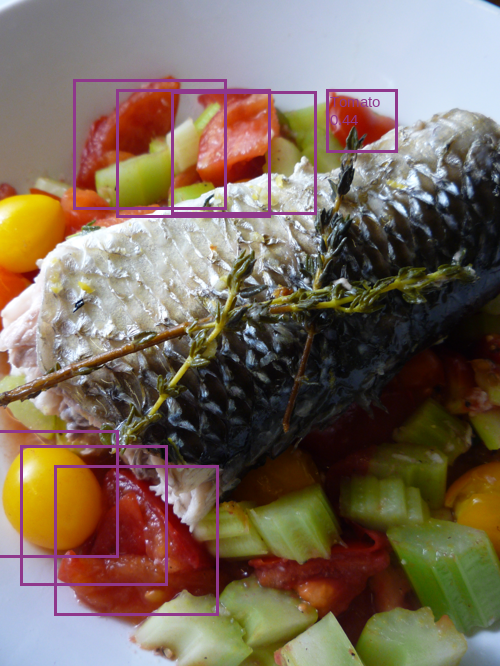

In [14]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
def draw_objects(draw, objs, scale_factor, labels):
	"""Draws the bounding box and label for each object."""
	COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
	for obj in objs:
		bbox = obj.bbox
		color = tuple(int(c) for c in COLORS[obj.id])
		draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
			(bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
			outline=color, width=3)
	font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
	draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
		'%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
		fill=color, font=font)
 # Load the TF Lite model
labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()
# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
	interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))
# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.4, image_scale=scale)
# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image


##1.8 Compile for the Edge TPU
First we need to download the Edge TPU Compiler:

In [22]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:10 

Before compiling the .tflite file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory. 
The Edge TPU has approximately 8 MB of SRAM for caching model paramaters, so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.
One way to elimiate the extra latency is to use model pipelining, which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model.

In [25]:
NUMBER_OF_TPUS = 1
! edgetpu_compiler $TFLITE_FILENAME

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 3392 ms.

Input model: efficientdet-lite-salad.tflite
Input size: 4.24MiB
Output model: efficientdet-lite-salad_edgetpu.tflite
Output size: 5.61MiB
On-chip memory used for caching model parameters: 4.24MiB
On-chip memory remaining for caching model parameters: 3.27MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: efficientdet-lite-salad_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3
See the operation log file for indivi

###1.8.1 Download the files

In [26]:
from google.colab import files
files.download(TFLITE_FILENAME)
files.download(TFLITE_FILENAME.replace('.tflite', '_edgetpu.tflite'))
files.download(LABELS_FILENAME)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>